In [3]:
import json
from tqdm import tqdm
import math
import numpy as np
import itertools
from scipy.optimize import minimize
import time
import copy
from scipy.stats import sem
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pylab
# custom 
from bayesian_learner import BayesianLearner
from utils import generate_structures

In [67]:
data = np.array(np.loadtxt('processed_data_and_figures/exp_1_one_player_known_structure/cond_1_BC_full.txt')).reshape(48,3,10)
count = 47 # n subjects in this condition

pp_means = data[count, 0, :]

data = data[:count, 0, :]

# l1_a = open('inferred_observations/exp_1_cond_2_l1_a.txt')
# l1_a = json.load(l1_a)

# l2_a = open('inferred_observations/exp_1_cond_2_l2_a.txt')
# l2_a = json.load(l2_a)

l1_b = open('inferred_observations/exp_1_cond_1_l1_b.txt')
l1_b = json.load(l1_b)

l1_c = open('inferred_observations/exp_1_cond_1_l1_c.txt')
l1_c = json.load(l1_c)

l2_b = open('inferred_observations/exp_1_cond_1_l2_b.txt')
l2_b = json.load(l2_b)

l2_c = open('inferred_observations/exp_1_cond_1_l2_c.txt')
l2_c = json.load(l2_c)

In [68]:
print(l1_b['0'])

{'0': {'1': 2.6055935562396964e-06, '0': 2.6055935562396773e-06}, '1': {'1': 2.6055935562397103e-06, '0': 0.9999571758476907}, '2': {'1': 4.7390545089927804e-05, '0': 1.0133676766139823}, '3': {'1': 4.7390545089934634e-05, '0': 2.012389961728166}, '4': {'1': 4.745411989473011e-05, '0': 2.515433548310476}, '5': {'1': 5.7927710036916486e-05, '0': 3.015108924699599}, '6': {'1': 0.0007683441953559502, '0': 3.5119342412924457}, '7': {'1': 0.0007683442755273131, '0': 4.485642044364196}, '8': {'1': 0.0007683945599753196, '0': 5.379264335149318}, '9': {'1': 0.0007695705230228913, '0': 6.063672096050271}}


In [69]:
# INSTANTIATING COMPETING LEARNERS
BL_sticky = BayesianLearner(prior_a = 1, prior_b = 1, n_choices = 7)


# FITTING RESULTS
# sticky baseline 
fitted_weights_sticky = []
ll_sticky_all_trials = []

# private 
fitted_weights_private = []
ll_private_all_trials = []

# naive 
fitted_weights_naive = []
ll_naive_all_trials = []

# heuristic more confident
fitted_weights_more_confident = []
ll_more_confident_all_trials = []

# struct
fitted_weights_struct = []
ll_struct_all_trials = []

# struct selected
fitted_weights_struct_selected = []
ll_struct_all_trials_selected = []

# private sticky
fitted_weights_private_sticky = []
ll_private_all_trials_sticky = []

# naive sticky
fitted_weights_naive_sticky = []
ll_naive_all_trials_sticky = []

# heuristic more confident
fitted_weights_more_confident_sticky = []
ll_more_confident_all_trials_sticky = []

# struct sticky
fitted_weights_struct_sticky = []
ll_struct_all_trials_sticky = []

# struct selected sticky
fitted_weights_struct_selected_sticky = []
ll_struct_all_trials_selected_sticky = []


# COLLATING JUDGMENTS AND PREDICTIONS FOR LOO CROSS VAL 
# judgments 
judgments_all_trials = []

# sticky baseline
predictions_sticky_all_trials = []

# private
predictions_private_all_trials = []

# naive
predictions_naive_all_trials = []

# heuristic more confident
predictions_more_confident_all_trials = []

# struct
predictions_struct_all_trials = []

# struct selected
predictions_struct_all_trials_selected = []

# private sticky
predictions_private_all_trials_sticky = []

# naive sticky
predictions_naive_all_trials_sticky = []

# naive sticky
predictions_more_confident_all_trials_sticky = []

# struct sticky
predictions_struct_all_trials_sticky = []

# struct sticky
predictions_struct_all_trials_sticky_selected = []


# MLE FITTING 
room_count = 0 # index over rooms 

for room in tqdm(data[:count]):
    
    params = [1, 1] # tau (for softmax) and weight (for stickyness) 
    bounds = [(0.001, 100.000), (0.000,0.999)]
    
    l1_b_room = l1_b[str(room_count)]
    l2_b_room = l2_b[str(room_count)]
    l1_c_room = l1_c[str(room_count)]
    l2_c_room = l2_c[str(room_count)]
    
    # print(l1_b_room)
    
    a_judgments = room
   
    # GETTING PREDICTIONS
    first_trial = np.repeat(1/7,7)  # first trial is random for all learners 
    private_predictions = {} 
    naive_social_predictions = {} 
    more_confident_predictions = {}
    structure_predictions = {}
  
    naive_evidence = []
    struct_evidence = []

    for trial in range(10):
        l1_b_trial = {'0' : 0, '1': 0} # uncomment if struct known
        l2_b_trial = {'0' : 0, '1': 0} # uncommnet 

        l1_c_trial = {'0' : 0, '1': 0} # uncomment 
        l2_c_trial = {'0' : 0, '1': 0} # u
        
        observation = 0
        if trial >= 1:
            observation = 1
        
            l1_b_trial = l1_b_room[str(trial - 1)] # uncomment if struct known
            l2_b_trial = l2_b_room[str(trial - 1)] # uncommnet 
            # l1_b_trial = l1_b_room[list(l1_b_room.keys())[0]][str(trial-1)] # uncomment if struct unknown
            # l2_b_trial = l2_b_room[list(l2_b_room.keys())[0]][str(trial-1)] # uncomment 
            l1_c_trial = l1_c_room[str(trial - 1)] # uncomment 
            l2_c_trial = l2_c_room[str(trial - 1)] # uncommnet 
            # l1_c_trial = l1_c_room[list(l1_c_room.keys())[0]][str(trial-1)] # uncommnet 
            # l2_c_trial = l2_c_room[list(l2_c_room.keys())[0]][str(trial-1)] # uncomment 

      
        # curr not used, can be uncommented if we want to work with uncertainty over structures  
        # naive_social_predictions[str(trial)] = np.zeros((7))
        #  structure_predictions[str(trial)] = np.zeros((7))
        # probs = structure_probs[str(room_count)][str(trial)]
        # struct_idx = 0
        #  for struct in structures:
        # print(l1_b_room)
        # print(l1_b_trial, l2_b_trial)
        # l2_b_trial = l2_b_room[str(trial)]
        # print(l2_b_room)
        # l2_b_trial = l2_b_room[str(struct_idx)][str(trial)]
        # l2_c_trial = l2_c_room[str(struct_idx)][str(trial)]
        # print(l1_b_trial)
        # prob = probs[struct_idx]
        prob = 1 # prob of struct curr just a delta 
        # print(observation)
        # private predictions (level 0)  
        BL_private = BayesianLearner(prior_a = 1 + observation, prior_b = 1, n_choices=7) 
        private_predictions[str(trial)] = BL_private.discrete_beta()
        # print(BL_private.discrete_beta())
        
        # naive social predictions (level 1)  
        total_alpha = 1 + l1_b_trial[str(1)] + l1_c_trial[str(1)] + observation 
        total_beta = 1 + l1_b_trial[str(0)] + l1_c_trial[str(0)] 
        BL_naive = BayesianLearner(prior_a = total_alpha , prior_b = total_beta , n_choices = 7)
        naive_social_predictions[str(trial)] = np.array(BL_naive.discrete_beta())
    
        # more confdient prediction
        total_alpha = 1 + l1_b_trial[str(1)] + observation 
        total_beta = 1 + l1_b_trial[str(0)] 
        BL_more_confident = BayesianLearner(prior_a = total_alpha , prior_b = total_beta , n_choices = 7)
        more_confident_predictions[str(trial)] = np.array(BL_more_confident.discrete_beta())

        # structure predictions (level 2)
        total_alpha = 1 + l2_b_trial[str(1)] + l2_c_trial[str(1)] + observation
        total_beta = 1 + l2_b_trial[str(0)] + l2_c_trial[str(0)]
        BL_struct = BayesianLearner(prior_a = total_alpha , prior_b = total_beta , n_choices = 7)
        structure_predictions[str(trial)] = np.array(BL_struct.discrete_beta())

        # struct_idx += 1

    # appending predictions and judgments for all trials 
    predictions_private_all_trials.append(private_predictions)
    predictions_naive_all_trials.append(naive_social_predictions)
    predictions_more_confident_all_trials.append(more_confident_predictions)
    predictions_struct_all_trials.append(structure_predictions)
    judgments_all_trials.append(a_judgments)
    
    # MLE FITTING PER ROOM
    
    # sticky baseline
    res_sticky = minimize(BL_sticky.sticky_baseline_prediction, params, args = (a_judgments),method='L-BFGS-B', bounds = bounds)
    fitted_weights_sticky.append(res_sticky.x)
    
    ll_sticky = BL_sticky.sticky_baseline_prediction([res_sticky.x[0]], a_judgments)
    ll_sticky_all_trials.append(-ll_sticky)
    
    # private learner
    res_priv = minimize(BL_private.fit_predictions, params, args = (private_predictions , a_judgments, False, 'private'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_private.append(res_priv.x)

    ll_private = BL_private.fit_predictions([res_priv.x[0], res_priv.x[1]], private_predictions , a_judgments, False, 'private')
    ll_private_all_trials.append(-ll_private)
    
    # naive learner 
    res_naive = minimize(BL_naive.fit_predictions, params, args = (naive_social_predictions , a_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_naive.append(res_naive.x)

    ll_naive = BL_naive.fit_predictions([res_naive.x[0], res_naive.x[1]], naive_social_predictions , a_judgments, False, 'naive')
    ll_naive_all_trials.append(-ll_naive)
    
    # more confident heuristic
    res_more_confident = minimize(BL_more_confident.fit_predictions, params, args = (more_confident_predictions , a_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_more_confident.append(res_more_confident.x)

    ll_more_confident = BL_more_confident.fit_predictions([res_more_confident.x[0], res_more_confident.x[1]], more_confident_predictions , a_judgments, False, 'naive')
    ll_more_confident_all_trials.append(-ll_more_confident)
    
    
    # structure learner 
    res_struct = minimize(BL_struct.fit_predictions, params, args = (structure_predictions , a_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_struct.append(res_struct.x)

    ll_struct = BL_struct.fit_predictions([res_struct.x[0], res_struct.x[1]], structure_predictions , a_judgments, False, 'naive')
    ll_struct_all_trials.append(-ll_struct)
    
    # private learner sticky
    res_priv_sticky = minimize(BL_private.fit_predictions, params, args = (private_predictions , a_judgments, True, 'private'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_private_sticky.append(res_priv_sticky.x)

    ll_private_sticky = BL_private.fit_predictions([res_priv_sticky.x[0], res_priv_sticky.x[1]], private_predictions , a_judgments, True, 'private')
    ll_private_all_trials_sticky.append(-ll_private_sticky)
    
    # naive learner sticky
    res_naive_sticky = minimize(BL_naive.fit_predictions, params, args = (naive_social_predictions , a_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_naive_sticky.append(res_naive_sticky.x)

    ll_naive_sticky = BL_naive.fit_predictions([res_naive_sticky.x[0], res_naive_sticky.x[1]], naive_social_predictions , a_judgments, True, 'naive')
    ll_naive_all_trials_sticky.append(-ll_naive_sticky)
    
    # naive learner sticky
    res_more_confident_sticky = minimize(BL_more_confident.fit_predictions, params, args = (more_confident_predictions , a_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_more_confident_sticky.append(res_more_confident_sticky.x)

    ll_more_confident_sticky = BL_more_confident.fit_predictions([res_more_confident_sticky.x[0], res_more_confident_sticky.x[1]], more_confident_predictions , a_judgments, True, 'naive')
    ll_more_confident_all_trials_sticky.append(-ll_more_confident_sticky)
    
    # structure learner sticky
    res_struct_sticky = minimize(BL_struct.fit_predictions, params, args = (structure_predictions , a_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    fitted_weights_struct_sticky.append(res_struct_sticky.x)

    ll_struct_sticky = BL_struct.fit_predictions([res_struct_sticky.x[0], res_struct_sticky.x[1]], structure_predictions , a_judgments, True, 'naive')
    ll_struct_all_trials_sticky.append(-ll_struct_sticky)

    room_count += 1   

100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


In [70]:
print('RESULTS')

model_ll = {'sticky': {'ll': ll_sticky_all_trials, 'n_param': 1}, 
            'private': {'ll': ll_private_all_trials, 'n_param': 1},
            'naive': {'ll': ll_naive_all_trials, 'n_param': 1},
            'more confident': {'ll': ll_more_confident_all_trials, 'n_param': 1},
            'struct': {'ll': ll_struct_all_trials, 'n_param': 1},
            'private sticky': {'ll': ll_private_all_trials_sticky, 'n_param': 2},
            'naive sticky': {'ll': ll_naive_all_trials_sticky, 'n_param': 2},
            'more confident sticky': {'ll': ll_more_confident_all_trials_sticky, 'n_param': 1},
            'struct sticky': {'ll': ll_struct_all_trials_sticky, 'n_param': 2}}


params = {'sticky': fitted_weights_sticky, 
          'private': fitted_weights_private,
          'naive': fitted_weights_naive,
          'more confident': fitted_weights_more_confident,
          'struct': fitted_weights_struct,
          'private sticky': fitted_weights_private_sticky, 
          'naive sticky': fitted_weights_naive_sticky, 
          'more confident sticky': fitted_weights_more_confident_sticky,
          'struct sticky': fitted_weights_struct_sticky}

for model in model_ll.keys():
    print()
    print(model)
    print('total ll across rooms', np.sum(model_ll[model]['ll']))
    print('total BIC across rooms', np.sum([-2 * i + model_ll[model]['n_param'] * np.log(10) for i in model_ll[model]['ll']]))
    print('average room ll', np.sum(model_ll[model]['ll'])/(count))
    print('average trial ll', np.sum(model_ll[model]['ll'])/(10*count))

    taus = []
    weights = []

    for p in params[model]:
        taus.append(p[0])
        weights.append(p[1])
    
    print('median tau', np.median(taus))
    print('mean tau', np.mean(taus))
    print('median weight', np.median(weights))
    print('mean weight', np.mean(weights))


RESULTS

sticky
total ll across rooms -464.8334750337949
total BIC across rooms 1037.8884494383099
average room ll -9.890073936889253
average trial ll -0.9890073936889253
median tau 0.9976358799838646
mean tau 1.5455644252066867
median weight 0.999
mean weight 0.9990000000000003

private
total ll across rooms -642.2196341061702
total BIC across rooms 1392.6607675830605
average room ll -13.664247534173835
average trial ll -1.3664247534173835
median tau 0.44774929265581276
mean tau 1.4062643861996793
median weight 0.999
mean weight 0.9990000000000003

naive
total ll across rooms -609.8630322133457
total BIC across rooms 1327.9475637974122
average room ll -12.975809196028631
average trial ll -1.2975809196028631
median tau 0.497001886993166
mean tau 0.8136972506981354
median weight 0.999
mean weight 0.9990000000000003

more confident
total ll across rooms -699.075158209015
total BIC across rooms 1506.3718157887506
average room ll -14.87393953636202
average trial ll -1.487393953636202
media

In [71]:
loo_loglikelihoods_sticky = []
loo_parameters_sticky = []

loo_loglikelihoods_private = []
loo_parameters_private = []

loo_loglikelihoods_naive = []
loo_parameters_naive = []

loo_loglikelihoods_more_confident = []
loo_parameters_more_confident = []

loo_loglikelihoods_struct = []
loo_parameters_struct = []

loo_loglikelihoods_private_sticky = []
loo_parameters_private_sticky = []

loo_loglikelihoods_naive_sticky = []
loo_parameters_naive_sticky = []


loo_loglikelihoods_more_confident_sticky = []
loo_parameters_more_confident_sticky = []

loo_loglikelihoods_struct_sticky = []
loo_parameters_struct_sticky = []

for room in tqdm(range(count)):
    training_judgments = copy.deepcopy(judgments_all_trials)
    training_judgments.pop(room)    # training judgments (all except 1)p
   
    # private 
    private_training_predictions = copy.deepcopy(predictions_private_all_trials)
    private_training_predictions.pop(room)
    
    # naive 
    naive_training_predictions = copy.deepcopy(predictions_naive_all_trials)
    naive_training_predictions.pop(room)
    
    # more confident
    more_confident_training_predictions = copy.deepcopy(predictions_more_confident_all_trials)
    more_confident_training_predictions.pop(room)
    
    # struct
    struct_training_predictions = copy.deepcopy(predictions_struct_all_trials)
    struct_training_predictions.pop(room)
    
    params = [1, 1] 
    bounds = [(0.001, 100.000), (0.000,0.999)]
    
    param_sticky = [1]
    bounds_sticky =  [(0.001, 100.000)]
    
 
    
    # sticky
    res_sticky_training = minimize(BL_sticky.sticky_baseline_prediction_all_trials, param_sticky, args = (training_judgments), method='L-BFGS-B', bounds = bounds_sticky)
    ll_sticky_left_out = BL_sticky.sticky_baseline_prediction_all_trials([res_sticky_training.x[0]], [judgments_all_trials[room]])

    loo_loglikelihoods_sticky.append(ll_sticky_left_out)
    loo_parameters_sticky.append({str(room): res_sticky_training.x})
    
    # private 
    res_priv_training = minimize(BL_private.fit_predictions_all_trials, params, args = (private_training_predictions, training_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_priv_left_out = BL_private.fit_predictions([res_priv_training.x[0], res_priv_training.x[1]], predictions_private_all_trials[room] , judgments_all_trials[room], False, 'private')

    loo_loglikelihoods_private.append(ll_priv_left_out)
    loo_parameters_private.append({str(room): res_priv_training.x})
    
    # naive
    res_naive_training = minimize(BL_naive.fit_predictions_all_trials, params, args = (naive_training_predictions, training_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_naive_left_out = BL_naive.fit_predictions([res_naive_training.x[0], res_naive_training.x[1]], predictions_naive_all_trials[room] , judgments_all_trials[room], False, 'private')

    loo_loglikelihoods_naive.append(ll_naive_left_out)
    loo_parameters_naive.append({str(room): res_naive_training.x})
    
    # more confident
    res_more_confident_training = minimize(BL_more_confident.fit_predictions_all_trials, params, args = (more_confident_training_predictions, training_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_more_confident_left_out = BL_more_confident.fit_predictions([res_more_confident_training.x[0], res_more_confident_training.x[1]], predictions_more_confident_all_trials[room] , judgments_all_trials[room], False, 'private')

    loo_loglikelihoods_more_confident.append(ll_more_confident_left_out)
    loo_parameters_more_confident.append({str(room): res_more_confident_training.x})
    
    # struct
    res_struct_training = minimize(BL_struct.fit_predictions_all_trials, params, args = (struct_training_predictions, training_judgments, False, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_struct_left_out = BL_struct.fit_predictions([res_struct_training.x[0], res_struct_training.x[1]], predictions_struct_all_trials[room] , judgments_all_trials[room], False, 'private')

    loo_loglikelihoods_struct.append(ll_struct_left_out)
    loo_parameters_struct.append({str(room): res_struct_training.x})  
    
     # private 
    res_priv_training_sticky = minimize(BL_private.fit_predictions_all_trials, params, args = (private_training_predictions, training_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_priv_left_out_sticky = BL_private.fit_predictions([res_priv_training_sticky.x[0], res_priv_training_sticky.x[1]], predictions_private_all_trials[room] , judgments_all_trials[room], True, 'private')

    loo_loglikelihoods_private_sticky.append(ll_priv_left_out_sticky)
    loo_parameters_private_sticky.append({str(room): res_priv_training_sticky.x})
    
    # naive
    res_naive_training_sticky = minimize(BL_naive.fit_predictions_all_trials, params, args = (naive_training_predictions, training_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_naive_left_out_sticky = BL_naive.fit_predictions([res_naive_training_sticky.x[0], res_naive_training_sticky.x[1]], predictions_naive_all_trials[room] , judgments_all_trials[room], True, 'private')

    loo_loglikelihoods_naive_sticky.append(ll_naive_left_out_sticky)
    loo_parameters_naive_sticky.append({str(room): res_naive_training_sticky.x})
    
    # more confident
    res_more_confident_training_sticky = minimize(BL_more_confident.fit_predictions_all_trials, params, args = (more_confident_training_predictions, training_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_more_confident_left_out_sticky = BL_more_confident.fit_predictions([res_more_confident_training_sticky.x[0], res_more_confident_training_sticky.x[1]], predictions_more_confident_all_trials[room] , judgments_all_trials[room], True, 'private')

    loo_loglikelihoods_more_confident_sticky.append(ll_more_confident_left_out_sticky)
    loo_parameters_more_confident_sticky.append({str(room): res_more_confident_training_sticky.x})
    
    # struct
    res_struct_training_sticky = minimize(BL_struct.fit_predictions_all_trials, params, args = (struct_training_predictions, training_judgments, True, 'naive'),method='L-BFGS-B', bounds = bounds)
    ll_struct_left_out_sticky = BL_struct.fit_predictions([res_struct_training_sticky.x[0], res_struct_training_sticky.x[1]], predictions_struct_all_trials[room] , judgments_all_trials[room], True, 'private')

    loo_loglikelihoods_struct_sticky.append(ll_struct_left_out_sticky)
    loo_parameters_struct_sticky.append({str(room): res_struct_training_sticky.x})  

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [05:14<00:00,  6.70s/it]


In [73]:
means = []
stds = []
 
loo_lls = {
           'private': loo_loglikelihoods_private,
           'naive': loo_loglikelihoods_naive,
           'struct': loo_loglikelihoods_struct,
           'private sticky': loo_loglikelihoods_private_sticky, 
           'struct sticky': loo_loglikelihoods_struct_sticky,
           'naive sticky': loo_loglikelihoods_naive_sticky}

for model in loo_lls.keys():
    print()
    print(model)
    print('total error', np.sum(loo_lls[model]))
    print('mean error', np.mean(loo_lls[model]))
    means.append(np.mean(loo_lls[model]))
    stds.append(sem(loo_lls[model]))

loo_n_best = {'base': 0,
              'private': 0,
              'naive': 0,
              'struct': 0,
              'private sticky': 0, 
              'struct sticky': 0,
              'naive sticky': 0,}

for room in range(count):
    loo_errors = [19.459101490553135]
    for model in loo_lls.keys():
        loo_errors.append(loo_lls[model][room])
    
    best = loo_errors.index(min(loo_errors))
    
    if loo_errors.count(min(loo_errors)) > 1:
        print('warning')
    
    loo_n_best[list(loo_n_best.keys())[best]] += 1

print()
print('N BEST')
print(loo_n_best)

# parameters 
tau_private = []
tau_naive = []
tau_struct = []
tau_private_sticky = []
tau_naive_sticky = []
tau_struct_sticky = []

pi_private_sticky = []
pi_naive_sticky = []
pi_struct_sticky = []



for i in range(count):
    # tau
    tau_private.append(loo_parameters_private[i][str(i)][0])
    tau_naive.append(loo_parameters_naive[i][str(i)][0])
    tau_struct.append(loo_parameters_struct[i][str(i)][0])
    tau_private_sticky.append(loo_parameters_private_sticky[i][str(i)][0])
    tau_naive_sticky.append(loo_parameters_naive_sticky[i][str(i)][0])
    tau_struct_sticky.append(loo_parameters_struct_sticky[i][str(i)][0])
    
    # pi
    pi_private_sticky.append(loo_parameters_private_sticky[i][str(i)][1])
    pi_naive_sticky.append(loo_parameters_naive_sticky[i][str(i)][1])
    pi_struct_sticky.append(loo_parameters_struct_sticky[i][str(i)][1])

print('taus')
print(np.median(tau_private))
print(np.median(tau_naive))
print(np.median(tau_struct))
print(np.median(tau_private_sticky))
print(np.median(tau_naive_sticky))
print(np.median(tau_struct_sticky))
print('pis')
print(np.median(pi_private_sticky))
print(np.median(pi_naive_sticky))
print(np.median(pi_struct_sticky))


private
total error 773.7004910563851
mean error 16.461712575667768

naive
total error 673.0008267966184
mean error 14.319166527587626

struct
total error 664.4899148533551
mean error 14.138083294752237

private sticky
total error 614.2168106288302
mean error 13.068442779336813

struct sticky
total error 544.9062409137184
mean error 11.59374980667486

naive sticky
total error 515.7337661824904
mean error 10.973058854946604

N BEST
{'base': 0, 'private': 0, 'naive': 6, 'struct': 6, 'private sticky': 0, 'struct sticky': 15, 'naive sticky': 20}
taus
0.25039848804455067
0.47685248930349156
0.506054113255114
0.2700641919865305
0.7175090917919469
0.5670798065701501
pis
0.47144119736101897
0.45648322278788644
0.42145151422461896


In [74]:
# getting inferred parameters
ground_truth_alpha = [0, 1, 1, 2, 2, 2, 2, 2, 2, 2]
ground_truth_beta =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

private_alpha = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
private_beta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

naive_alpha = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
naive_beta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

struct_alpha = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
struct_beta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

agent_a_alpha = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
agent_a_beta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

participant_a_alpha_l1 = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
participant_a_beta_l1 =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

participant_a_alpha_l2 = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
participant_a_beta_l2 =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# count = 21
for trial in range(10):
    l1_alpha = 0
    l1_beta = 0
    l2_alpha = 0
    l2_beta = 0
    a_alpha_l1 = 0
    a_beta_l1 = 0
    a_alpha_l2 = 0
    a_beta_l2 = 0
    
#     for room_count in range(count):
#         l1_b_trial = l1_b[str(room_count)][str(trial)]
    
#         l1_c_trial = l1_c[str(room_count)][str(trial)]
#         l2_c_trial = l2_c[str(room_count)][str(trial)]
        
#         l1_a_trial = l1_a[str(room_count)][str(trial)]
#         l2_a_trial = l2_a[str(room_count)][str(trial)]

#         l1_alpha += l1_b_trial[str(1)] + l1_c_trial[str(1)] 
#         l1_beta += l1_b_trial[str(0)] + l1_c_trial[str(0)] 
#         l2_alpha += l1_b_trial[str(1)] + l2_c_trial[str(1)] 
#         l2_beta += l1_b_trial[str(0)] + l2_c_trial[str(0)] 
    
    for room_count in range(count):
        # print('hi')
        

        # for prob in range(16):
        # structure_probs[str(room_count)][str(trial)]:
            # prob = 1/16
            # print(prob)
        
        # l1_a_trial = l1_a[str(room_count)][str(trial)]
        # l2_a_trial = l2_a[str(room_count)][str(trial)]
        # l2_a_trial = l2_a[str(room_count)][list(l2_a[str(room_count)].keys())[0]][str(trial)]
# 
        
        # print(l2_a_trial)
        
        l1_b_trial = l1_b[str(room_count)][str(trial)]
        l2_b_trial = l2_b[str(room_count)][str(trial)]
        # l2_b_trial = l2_b[str(room_count)][str(struct_idx)][str(trial)]
        # print(l2_b[str(room_count)][list(l2_b[].keys())[0]])
        # l1_b_trial = l1_b[str(room_count)][list(l1_b[str(room_count)].keys())[0]][str(trial)]
        # l2_b_trial = l2_b[str(room_count)][list(l2_b[str(room_count)].keys())[0]][str(trial)]
# # 
        l1_c_trial = l1_c[str(room_count)][str(trial)]
        l2_c_trial = l2_c[str(room_count)][str(trial)]
        # l2_c_trial = l2_c[str(room_count)][str(struct_idx)][str(trial)]
        # l1_c_trial = l1_c[str(room_count)][list(l1_c[str(room_count)].keys())[0]][str(trial)]
        # l2_c_trial = l2_c[str(room_count)][list(l2_c[str(room_count)].keys())[0]][str(trial)]

        
        
#         a_alpha_l1 += (l1_a_trial[str(1)] + l1_a_trial[str(1)]) 
#         a_beta_l1 += (l1_a_trial[str(0)] + l1_a_trial[str(0)]) 
        
#         a_alpha_l2 += (l2_a_trial[str(1)] + l2_a_trial[str(1)]) 
#         a_beta_l2 += (l2_a_trial[str(0)] + l2_a_trial[str(0)]) 
        
        
        l1_alpha += (l1_b_trial[str(1)] + l1_c_trial[str(1)]) 
        l1_beta += (l1_b_trial[str(0)] + l1_c_trial[str(0)]) 
        l2_alpha += (l2_b_trial[str(1)] + l2_c_trial[str(1)]) 
        l2_beta += (l2_b_trial[str(0)] + l2_c_trial[str(0)])
        # struct_idx += 1

#     # print(a_alpha)
#     participant_a_alpha_l1[trial] += a_alpha_l1/count
#     participant_a_beta_l1[trial] += a_beta_l1/count
    
#     participant_a_alpha_l2[trial] += a_alpha_l2/count
#     participant_a_beta_l2[trial] += a_beta_l2/count
    
    naive_alpha[trial] += l1_alpha/count
    naive_beta[trial] += l1_beta/count
    struct_alpha[trial] += l2_alpha/count
    struct_beta[trial] += l2_beta/count
# print(participant_a_alpha_l1)
# print(struct_alpha) 
print(struct_beta)
print(ground_truth_beta)

[5.21118711247935e-06, 0.9999623872275567, 1.0133728879942348, 2.0123951731089416, 2.515438761543845, 3.015114859218572, 3.5119773528530884, 4.486085062508804, 5.3798338053711285, 6.064453447685822]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


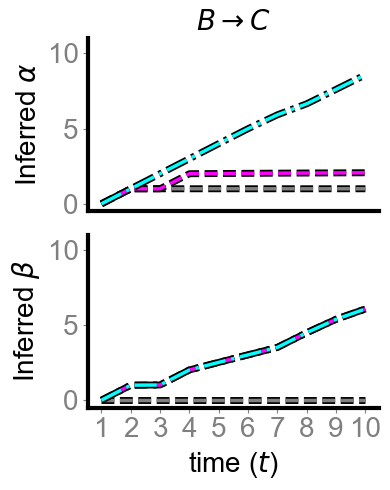

In [75]:
# GLOBAL PLOT PARAMETERS
plot_params = {'legend.fontsize': 'large',
               'axes.labelsize': 'large',
               'axes.titlesize':'20',
               'axes.labelsize':'20',
               'xtick.labelsize':'20',
               'font.family': 'Arial',
               'xtick.color':'grey',
               'ytick.color':'grey',
               'ytick.labelsize':'20',
               'axes.linewidth': '3'}


pylab.rcParams.update(plot_params)

def inferredParam_plot(data):
    fig, axs = plt.subplots(2, 1, figsize=(4,5),sharey=True) 
    axs[0].title.set_text(r'$ B\rightarrow C$')
    # truth
    # axs[0].plot(np.arange(1, 11,1), data[0], label="A",linewidth=2.5, color='black',linestyle='-',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # axs[1].plot(np.arange(1, 11,1), data[1], label="B",linewidth=2.5, color='black',linestyle='-',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # private
    axs[0].plot(np.arange(1, 11,1), data[2], label="A",linewidth=2.5, color='grey',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    axs[1].plot(np.arange(1, 11,1), data[3], label="B",linewidth=2.5, color='grey',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # l1
    axs[0].plot(np.arange(1, 11,1), data[4], label="A",linewidth=2.5, color='magenta',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    axs[1].plot(np.arange(1, 11,1), data[5], label="B",linewidth=2.5, color='magenta',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # l2
    axs[0].plot(np.arange(1, 11,1), data[6], label="A",linewidth=2.5, color='cyan',linestyle='-.',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    axs[1].plot(np.arange(1, 11,1), data[7], label="B",linewidth=2.5, color='cyan',linestyle='-.',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    
    axs[1].set_ylim([-.5, 11])
    axs[1].set_xlabel(r'time ($t$)') 
    axs[1].set_xticks([1,2,3,4,5,6,7,8,9,10])
    axs[0].set_ylabel(r'')
    axs[1].set_ylabel(r'')
    axs[0].set_ylabel(r'Inferred $\alpha$')
    axs[1].set_ylabel(r'Inferred $\beta$')
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[1].set_yticks([0, 5, 10])
    axs[0].set_yticklabels([0,5,10])
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    
    # axs[1].legend([r'True State', r'$Level_0$', r'$Level_1$', r'$Level_2$'],loc='upper left', bbox_to_anchor=(-0.03, 1.1),ncol=2,fontsize=18, frameon=False,borderpad=0.1, labelspacing=0.1, handlelength=1, handletextpad=0.1, columnspacing=0.4)     
    
    fig.tight_layout()
    plt.savefig('test.pdf')
    plt.show()
    
inferredParam_plot([ground_truth_alpha, ground_truth_beta, 
            private_alpha, private_beta, 
            naive_alpha, naive_beta, 
            struct_alpha, struct_beta])

In [76]:
# mean predictions trace_plot representation 
average_truth = {}
average_l0 = {}
average_l1 = {}
average_l2 = {}

for trial in range(10):
    average_truth[trial] = []
    average_l0[trial] = []
    average_l1[trial] = []
    average_l2[trial] = []
    for room in range(count):
        judgs = np.array([-3,-2,-1,0,1,2,3])
        # truth 
        BL_truth = BayesianLearner(prior_a=1 + ground_truth_alpha[trial], prior_b=1 + ground_truth_beta[trial],n_choices=7)
        probs = np.array(BL_truth.discrete_beta())
        average_truth[trial].append(np.sum(probs * judgs))
        # l0
        probs = np.array(predictions_private_all_trials[room][str(trial)])
        average_l0[trial].append(np.sum(probs * judgs))
        # l1 
        probs = np.array(predictions_naive_all_trials[room][str(trial)])
        average_l1[trial] .append(np.sum(probs * judgs))
        # l2
        probs = np.array(predictions_struct_all_trials[room][str(trial)])
        average_l2[trial] .append(np.sum(probs * judgs))

# mean 
trial_means_truth = []
trial_means_l0 = []
trial_means_l1 = []
trial_means_l2 = []

for trial in range(10):
    trial_means_truth.append(np.mean(average_truth[trial]))
    trial_means_l0.append(np.mean(average_l0[trial]))
    trial_means_l1.append(np.mean(average_l1[trial]))
    trial_means_l2.append(np.mean(average_l2[trial]))

print('means')
print('truth')
print(trial_means_truth)
print(np.mean(trial_means_truth[5:]))
print()
print('l0')
print(trial_means_l0)
print(np.mean(trial_means_l0[5:]))
print()
print('l1')
print(trial_means_l1)
print(np.mean(trial_means_l1[5:]))
print()
print('l2')
print(trial_means_l2)
print(np.mean(trial_means_l2[5:]))
print('pp')
print(pp_means)
print(np.mean(pp_means[5:]))

print(len(average_l2[0]))

means
truth
[2.220446049250313e-16, 3.3306690738754696e-16, -0.6997084548104955, -0.5004717422162529, -0.8758255488784439, -1.1679487288459736, -1.4018648692296576, -1.5934765881027695, -1.7533790225988959, -1.888897355017033]
-1.561113312758866

l0
[2.220446049250313e-16, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435, 1.1428571428571435]
1.1428571428571435

l1
[2.220446049250313e-16, 1.1428534470350633, 3.965796147586964e-05, -0.011589757199304995, -0.007219515409651378, -0.2694207785557582, -0.4924819468877108, -0.6844826982384498, -1.0013235494208754, -1.2341032968331316]
-0.7363624539871851

l2
[2.220446049250313e-16, 1.1428534470350633, 3.965796147376022e-05, 0.6885847112699395, 0.4933969760479918, 0.6104636229698593, 0.6924723992784019, 0.7363865087301601, 0.5763660389851558, 0.5202073704678299]
0.6271791880862814
pp
[-0.0212766   0.91489362  0.25531915  0.06382979  0.

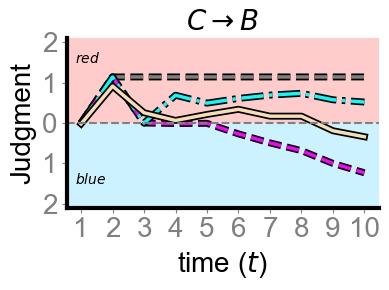

In [77]:
def pred_judg_plot(data):
    fig, axs = plt.subplots(1, 1, figsize=(4,3),sharey=True) 
    axs.title.set_text(r'$C \rightarrow B$')    
    # truth
    # axs.plot(np.arange(1, 11,1), data[0], label="A",linewidth=2.5, color='black',linestyle='-',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # private
    axs.plot(np.arange(1, 11,1), data[1], label="A",linewidth=2.5, color='grey',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # l1
    axs.plot(np.arange(1, 11,1), data[2], label="A",linewidth=2.5, color='magenta',linestyle='--',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # l2
    axs.plot(np.arange(1, 11,1), data[3], label="A",linewidth=2.5, color='cyan',linestyle='-.',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    # pp
    axs.plot(np.arange(1, 11,1), data[4], label="A",linewidth=2.5, color='wheat',linestyle='-',path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
  
    
    axs.set_ylim([-2.1, 2.1])
    axs.set_xlabel(r'time ($t$)') 
    axs.set_xticks([1,2,3,4,5,6,7,8,9,10])
    axs.set_ylabel(r'Judgment')
    axs.set_yticks([-2, -1, 0, 1, 2])
    axs.set_yticklabels([2, 1, 0, 1, 2])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    
    axs.axhline(y=0, color='grey', linestyle='--')
    axs.annotate(r'$red$', xy=(1, 1), xytext=(0.8, 1.5))
    axs.annotate(r'$blue$', xy=(1, 1), xytext=(0.8, -1.5))

 
    axs.axhspan(0, 2.1, facecolor='red', alpha=0.2)
    axs.axhspan(0, -2.1, facecolor='deepskyblue', alpha=0.2)
       
   
    
    # axs[0].legend([r'True State', r'$Level_0$', r'$Level_1$', r'$Level_2$', r'$Participant$'],loc='upper left', bbox_to_anchor=(-0.03, 1.1),ncol=2,fontsize=18, frameon=False,borderpad=0.1, labelspacing=0.1, handlelength=1, handletextpad=0.1, columnspacing=0.4)
    
    fig.tight_layout()
    plt.savefig('exp1_cond_3_pred_judg.pdf')
    # plt.show()
    
pred_judg_plot([trial_means_truth,
            trial_means_l0,
            trial_means_l1,
            trial_means_l2,
            pp_means])

FileNotFoundError: [Errno 2] No such file or directory: 'model_fits_plots/exp3_cond_1_loo_nBest.pdf'

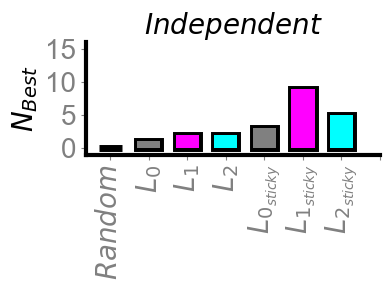

In [33]:
def nBest_plot(names, means, cols):
    fig, axs = plt.subplots(1, 1, figsize=(4,3),sharey=True) 
    axs.bar(x=names,height=means,path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
           color=cols, width=.6)
    axs.title.set_text(r'$Independent$')
    axs.set_ylim([-1, 16])
    axs.set_xticks([0,1,2,3,4,5,6,7])
    axs.set_yticks([0,5,10,15])
    axs.set_ylabel(r'$N_{Best}$')
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    plt.xticks(rotation = 90)
    fig.tight_layout()
    plt.savefig('model_fits_plots/exp3_cond_1_loo_nBest.pdf')
    plt.show()
    
# N BEST
data = {'base': 0, 'private': 1, 'naive': 2, 'struct': 2, 'private sticky': 3, 'naive sticky': 9, 'struct sticky': 5}
names = [r'$Random$', r'$L_{0}$', r'$L_{1}$', r'$L_{2}$', r'$L_{0_{sticky}}$', r'$L_{1_{sticky}}$',  r'$L_{2_{sticky}}$']
colors = ['lightgrey', 'grey', 'magenta', 'cyan', 'grey', 'magenta', 'cyan']
nBest_plot(names, list(data.values()), colors)

In [ ]:
# def bar_plot(names, means, stds, cols):
#     fig, axs = plt.subplots(1, 1, figsize=(4,3),sharey=True) 
#     axs.bar(x=names,height=means,yerr=stds,path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
#            color=cols, width=.6)
#     axs.title.set_text(r'${B \rightarrow C}$')
#     axs.set_ylim([-1.2, 24])
#     axs.set_xticks([0,1,2,3,4,5])
#     axs.set_ylabel(r'-LogL')
#     axs.set_yticks([0, 10, 20])
#     axs.set_yticklabels([0, 10,  20])
#     axs.spines['right'].set_visible(False)
#     axs.spines['top'].set_visible(False)
#     axs.axhline(y=19.459101490553135, color='grey', linestyle='--')
#     axs.annotate('Chance Performance', xy=(0, 19.459101490553135), xytext=(0.5, 20)
#              )
#     plt.xticks(rotation = 90)
#     axs.set_xticklabels(names)
#     fig.tight_layout()
#     # axs.legend([r'sticky', r'$L_0$', r'$L_1$', r'$L_2$'],loc='upper left', bbox_to_anchor=(-0.03, 1.1),ncol=2,fontsize=22, frameon=False,borderpad=0.1, labelspacing=0.1, handlelength=.4, handletextpad=0.1, columnspacing=0.4)
#     plt.savefig('model_fits_plots/exp3_cond_2_log_error.pdf')
#     plt.show()
# # data = {'base': 0, 'sticky': 2, 'private': 0, 'naive': 5, 'private sticky': 1, 'naive sticky': 13}
# names = [r'$L_{0}$', r'$L_{1}$', r'$L_{2}$', r'$L_{0_{sticky}}$', r'$L_{1_{sticky}}$',  r'$L_{2_{sticky}}$']
# colors = ['grey', 'magenta', 'cyan', 'grey', 'magenta', 'cyan']
# bar_plot(names, means, stds, colors)